In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models, utils
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
sn.set_palette("Reds")
%matplotlib inline

import time

In [2]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
train_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset',transform=train_transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset',transform=test_transform)

In [4]:
np.random.seed(10)
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train_idx
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [5]:
batch_size = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        #(in_chan, out_chan, size, stride, padding)
        self.conv1 = nn.Conv2d(3, 16, 10, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 20, 3, 1)
        # parameter - dropout probability
        self.dropout1 = nn.Dropout(0.5)
        #(((200-2)/2) - 2)/2 = 48.5; zaokrąglone w dół
        self.fc1 = nn.Linear(9*9*32, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X)) #rectified linear unit - activation function
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout1(X)
        X = X.view(-1, 9*9*32) 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # converting logits to odds

In [7]:
CNNmodel40 = ConvolutionalNetwork()
CNNmodel100 = ConvolutionalNetwork()

In [8]:
CNNmodel100.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [9]:
#ładowanie wag sieć 40 epok
CNNmodel40.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/siec_od_0_95%_lr_00001_ep40.pt'))

<All keys matched successfully>

In [10]:
#ładowanie wag sieć 100 epok
CNNmodel100.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/siec_od_0_95%_lr_00001_ep100.pt'))

<All keys matched successfully>

In [11]:
CNNmodel40.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [12]:
CNNmodel100.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(20, 20), stride=(3, 3), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2592, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

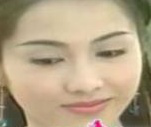

In [13]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/Colab Notebooks/dataset/without_mask/0_0_lizi_0103.jpg')
image

In [14]:
image_tensor = test_transform(image)
image_tensor = image_tensor.unsqueeze(0)

In [15]:
with torch.no_grad():
    output = CNNmodel40(image_tensor)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-3.7592, -0.0236]])
tensor(1)


'without_mask'

In [16]:
 class_list40 =[]
 for i, label in test_data:
  image_tensor = i.unsqueeze(0) 
  with torch.no_grad():
    output = CNNmodel40(image_tensor)
  pos = output[0].argmax()
  class_list40.append([class_names[pos], label])

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [17]:
 class_list100 =[]
 for i, label in test_data:
  image_tensor = i.unsqueeze(0) 
  with torch.no_grad():
    output = CNNmodel100(image_tensor)
  pos = output[0].argmax()
  class_list100.append([class_names[pos], label])

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [18]:
df40 = pd.DataFrame(class_list40, columns=['Real', 'Predicted'])
df100 = pd.DataFrame(class_list100, columns=['Real', 'Predicted'])

In [19]:
df40.loc[df40.Real == 'with_mask', "Real"] = 0
df40.loc[df40.Real == 'without_mask', "Real"] = 1
df100.loc[df100.Real == 'with_mask', "Real"] = 0
df100.loc[df100.Real == 'without_mask', "Real"] = 1

In [20]:
df40

,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3862,1,1
3863,1,1
3864,1,1
3865,0,1


In [21]:
df100

,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3862,1,1
3863,1,1
3864,1,1
3865,1,1


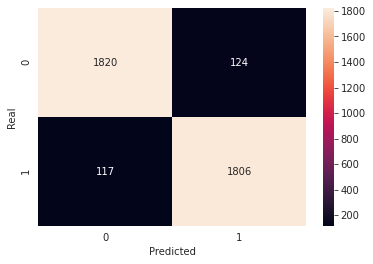

In [22]:
conf_matr40 =pd.crosstab(df40["Real"], df40["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr40, annot=True, fmt='g')
plt.show()

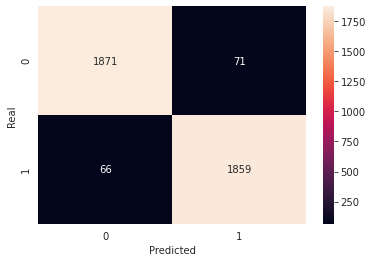

In [23]:
conf_matr100 =pd.crosstab(df100["Real"], df100["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr100, annot=True, fmt='g')
plt.show()

In [24]:
real40 = df40["Real"].values.tolist()
predicted40 = df40["Predicted"].values.tolist()
real100 = df100["Real"].values.tolist()
predicted100 = df100["Predicted"].values.tolist()

In [25]:
TPR40 = (conf_matr40[0][0])/(conf_matr40[0][0] + conf_matr40[1][0])
TNR40 = (conf_matr40[1][1])/(conf_matr40[1][1] + conf_matr40[0][1])
FPR40 = (conf_matr40[0][1])/(conf_matr40[0][1] + conf_matr40[1][1])
FNR40 = (conf_matr40[1][0])/(conf_matr40[1][0] + conf_matr40[0][0])
ACC40 = (conf_matr40[0][0] + conf_matr40[1][1])/(conf_matr40[1][0] + conf_matr40[1][1]+conf_matr40[0][0] + conf_matr40[0][1])

TPR100 = (conf_matr100[0][0])/(conf_matr100[0][0] + conf_matr100[1][0])
TNR100 = (conf_matr100[1][1])/(conf_matr100[1][1] + conf_matr100[0][1])
FPR100 = (conf_matr100[0][1])/(conf_matr100[0][1] + conf_matr100[1][1])
FNR100 = (conf_matr100[1][0])/(conf_matr100[1][0] + conf_matr100[0][0])
ACC100 = (conf_matr100[0][0] + conf_matr100[1][1])/(conf_matr100[1][0] + conf_matr100[1][1]+conf_matr100[0][0] + conf_matr100[0][1])

In [26]:
stats40 = pd.DataFrame([["TPR",TPR40],["TNR",TNR40],["FPR",FPR40],["FNR",FNR40],["ACC",ACC40]], columns=["Stats","Value"])
stats100 = pd.DataFrame([["TPR",TPR100],["TNR",TNR100],["FPR",FPR100],["FNR",FNR100],["ACC",ACC100]], columns=["Stats","Value"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


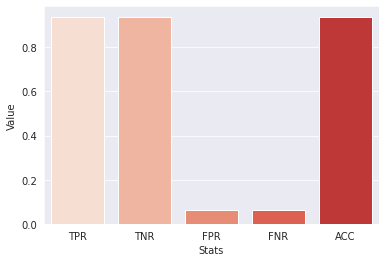

In [27]:
sn.barplot(stats40["Stats"], stats40["Value"])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


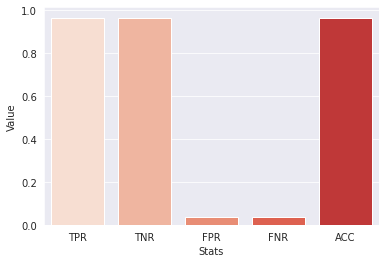

In [28]:
sn.barplot(stats100["Stats"], stats100["Value"],)
plt.show()

RESNET

In [29]:
res18_mod = torch.load('/content/drive/MyDrive/Colab Notebooks/model_transfer_res18.pt')


In [30]:
res18_mod.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

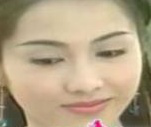

In [31]:
image

In [32]:
with torch.no_grad():
    output = res18_mod(image_tensor)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-2.7526,  2.4385]])
tensor(1)


'without_mask'

In [33]:
pred = res18_mod(image_tensor).argmax(dim=1)

In [34]:
pred

tensor([1])

In [35]:
 class_listRes =[]
 for i, label in test_data:
  image_tensor = i.unsqueeze(0) 
  with torch.no_grad():
    output = res18_mod(image_tensor)
  pos = output[0].argmax()
  class_listRes.append([class_names[pos], label])

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [36]:
dfRes = pd.DataFrame(class_listRes, columns=['Real', 'Predicted'])
dfRes

,Real,Predicted
0,with_mask,0
1,with_mask,0
2,with_mask,0
3,with_mask,0
4,with_mask,0
...,...,...
3862,without_mask,1
3863,without_mask,1
3864,without_mask,1
3865,without_mask,1


In [37]:
dfRes.loc[dfRes.Real == 'with_mask', "Real"] = 0
dfRes.loc[dfRes.Real == 'without_mask', "Real"] = 1

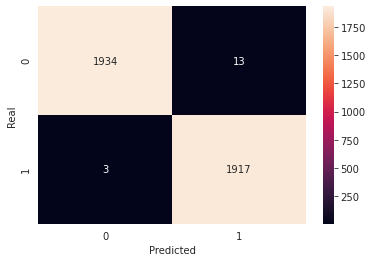

In [38]:
conf_matrRes =pd.crosstab(dfRes["Real"], dfRes["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matrRes, annot=True, fmt='g')
plt.show()

In [39]:
TPRRes = (conf_matrRes[0][0])/(conf_matrRes[0][0] + conf_matrRes[1][0])
TNRRes = (conf_matrRes[1][1])/(conf_matrRes[1][1] + conf_matrRes[0][1])
FPRRes = (conf_matrRes[0][1])/(conf_matrRes[0][1] + conf_matrRes[1][1])
FNRRes = (conf_matrRes[1][0])/(conf_matrRes[1][0] + conf_matrRes[0][0])
ACCRes = (conf_matrRes[0][0] + conf_matrRes[1][1])/(conf_matrRes[1][0] + conf_matrRes[1][1]+conf_matrRes[0][0] + conf_matrRes[0][1])

In [40]:
statsRes = pd.DataFrame([["TPR",TPRRes],["TNR",TNRRes],["FPR",FPRRes],["FNR",FNRRes],["ACC",ACCRes]], columns=["Stats","Value"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


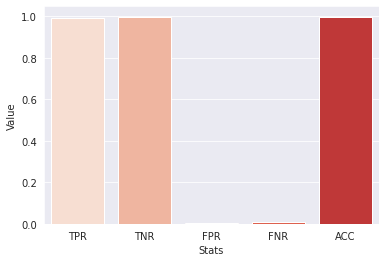

In [41]:
sn.barplot(statsRes["Stats"], statsRes["Value"],)
plt.show()

DEEP DREAM

In [42]:
#This part is taken from fast.ai course, it allows to attach a hook to a model or its certain layer
#Sadly i cant find working link anymore as i had this cell in my disc for a long time
#So this will rather not be included in our report
#Just did it to get some knoledge how our network works
class SaveFeatures():
    def __init__(self, m, backward=False): 
      if backward==False:
        self.hook = m.register_forward_hook(self.hook_fn)
      else:
        self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
      self.features = ((output.cpu()).data).numpy()
      self.input = input
      self.output = output
    def remove(self): self.hook.remove()

In [43]:
def calc_grad(tensor, model):     
  var = Variable((tensor.unsqueeze(0)).cpu(), requires_grad=True)
  model.zero_grad() #we need to set the gradients to zero as torch tends to acumulate it 
  feature = SaveFeatures(model)
  pred = model(var)
  loss = feature.output[0].norm()
  loss.backward()
  return var.grad.data.squeeze()

In [44]:
denorm = transforms.Compose([ transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1/0.229, 1/0.224, 1/0.225 ])])

In [45]:
#This cell is also an effet of massive stack overflow abusse
#as i have been encountering issues almost in each line
#therefore there are at least several sources behind it
#but i woudnt say that this is a copy of something that exists

def dream(image, model, iterations, res):
  tensor = test_transform(image)
  for i in range(iterations):
    grad = calc_grad(tensor, model)
    tensor.data = tensor.data + res * grad.data

  img_out = tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

In [46]:
def dreamImg(Img, model, it, res):
  img = Image.open(Img)
  dimg = dream(img, model, it, res)

  fig = plt.figure(figsize = (10 , 10))
  plt.imshow(dimg)

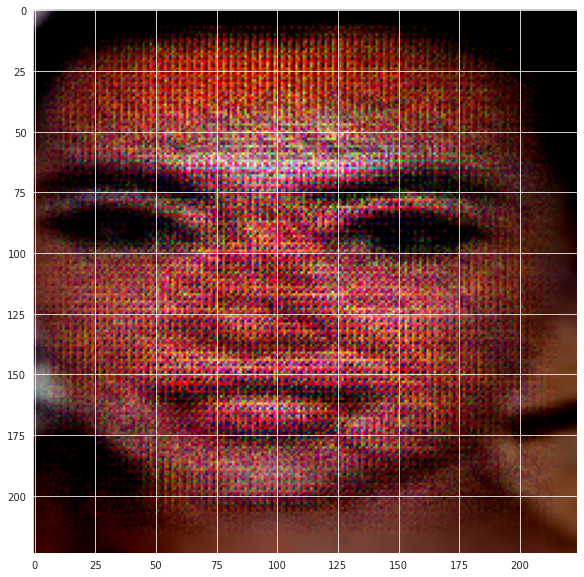

In [47]:
dreamImg("/content/drive/MyDrive/Colab Notebooks/dataset/without_mask/0_0_aidai_0014.jpg", CNNmodel100, 1000, 5)

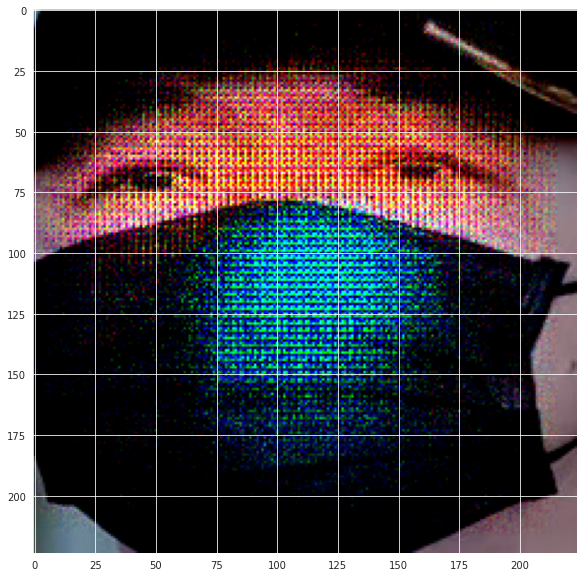

In [48]:
dreamImg("/content/drive/MyDrive/Colab Notebooks/dataset/with_mask/0_0_0 copy 52.jpg", CNNmodel100, 1000, 5)

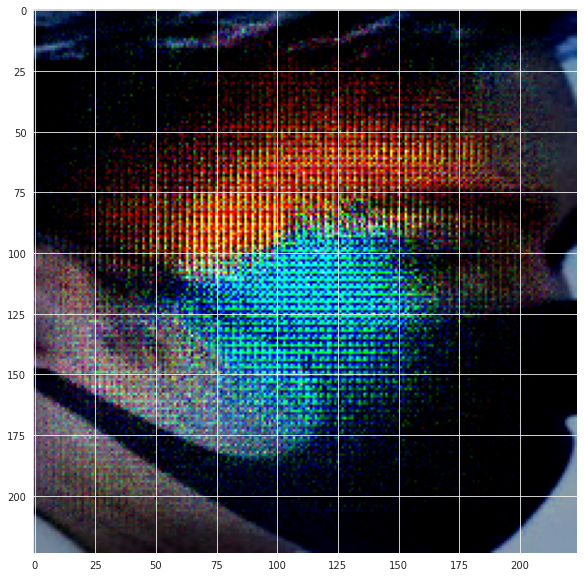

In [49]:
dreamImg("/content/drive/MyDrive/Colab Notebooks/dataset/with_mask/0_0_1 copy 13.jpg", CNNmodel100, 1000, 5)

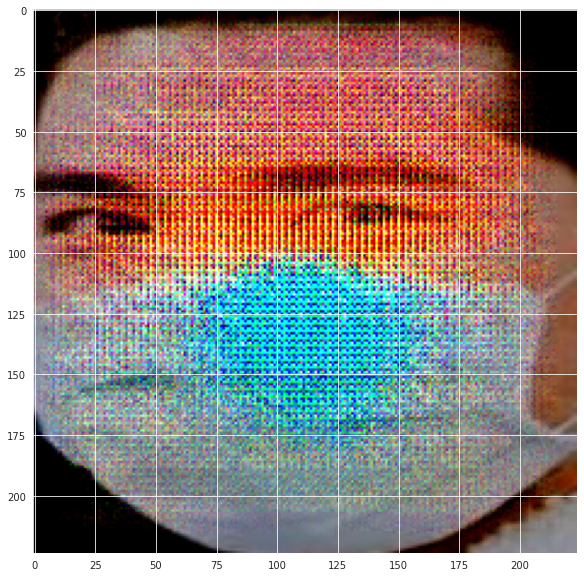

In [50]:
dreamImg("/content/drive/MyDrive/Colab Notebooks/dataset/with_mask/0_0_2 copy 13.jpg", CNNmodel100, 1000, 5)

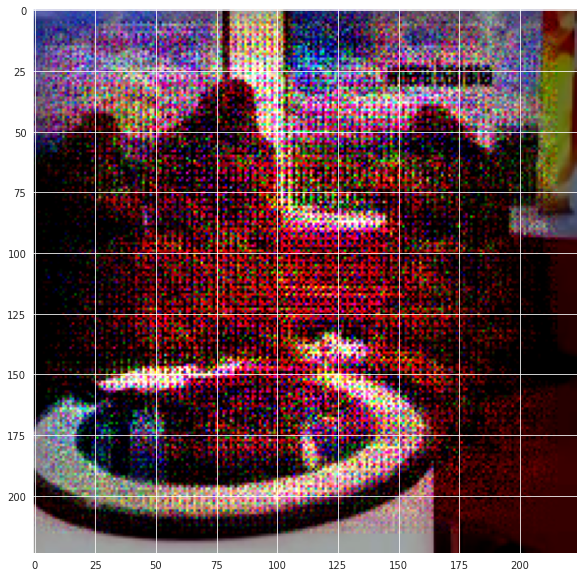

In [51]:
dreamImg("/content/drive/MyDrive/wherebanana.jpg", CNNmodel100, 1000, 10)